In [1]:
import os
import warnings
import keras
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import newaxis
from keras.layers.core import  Activation, Dropout
from keras.models import Model
from keras.layers import Input, Embedding,LSTM, Dense,TimeDistributed
from keras import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import concatenate

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder



Using TensorFlow backend.


In [2]:
seq_len = 1
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(),list()
    for i in range(n_in, 0 ,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis =1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace = True)
    return agg

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()
def predict_sequences_full(model, data, window_size):
    
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, window_size-1,predicted[-1], axis=0)
    return predicted

In [3]:
dataset_stock = read_csv('gap1.csv', header = 0, index_col=0)
values_stock = dataset_stock.values
encoder = LabelEncoder()
values_stock[:,0] = encoder.fit_transform(values_stock[:,0])
values_stock = values_stock.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_stock = scaler.fit_transform(values_stock)
reframed_stock = series_to_supervised(scaled_stock, 1, 1)
print(reframed_stock.head())

   var1(t-1)   var1(t)
1   0.488038  0.435407
2   0.435407  0.617225
3   0.617225  0.401914
4   0.401914  0.559809
5   0.559809  0.397129


In [7]:
dataset_gap = read_csv('fai1.csv', header = 0, index_col=0)
values_gap = dataset_gap.values
encoder = LabelEncoder()
values_gap[:,0] = encoder.fit_transform(values_gap[:,0])
values_gap = values_gap.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_gap = scaler.fit_transform(values_gap)
reframed_gap = series_to_supervised(scaled_gap, 1, 1)
print(reframed_gap.head())


   var1(t-1)   var1(t)
1   0.182609  0.191304
2   0.191304  0.182609
3   0.182609  0.191304
4   0.191304  0.182609
5   0.182609  0.104348


In [6]:
dataset_fai = read_csv('stock1.csv', header = 0, index_col=0)
values_fai = dataset_fai.values
encoder = LabelEncoder()
values_fai[:,0] = encoder.fit_transform(values_fai[:,0])
values_fai = values_fai.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_fai = scaler.fit_transform(values_fai)
reframed_fai = series_to_supervised(scaled_fai, 1, 1)
print(reframed_fai.head())


   var1(t-1)   var1(t)
1   0.157798  0.161468
2   0.161468  0.150459
3   0.150459  0.177982
4   0.177982  0.166972
5   0.166972  0.179817


In [8]:
values_stock = reframed_stock.values
n_train_hours = 85
n_end = n_train_hours + 5
train_stock = values_stock[:n_train_hours, :]

test_stock = values_stock[n_train_hours: n_end :]

train_X_stock, train_y_stock = train_stock[:,:-1], train_stock[:, -1]

test_stock_X, test_stock_y = test_stock[:,:-1],test_stock[:,-1]

train_X_stock = train_X_stock.reshape((train_X_stock.shape[0], 1, train_X_stock.shape[1]))
test_stock_X = test_stock_X.reshape((test_stock_X.shape[0], 1, test_stock_X.shape[1]))
print(train_X_stock.shape, train_y_stock.shape, test_stock_X.shape, test_stock_y.shape)


((85, 1, 1), (85,), (5, 1, 1), (5,))


In [9]:
stock_input = Input(shape=(train_X_stock.shape[1], train_X_stock.shape[2]), dtype='float32', name='stock_input')
print stock_input

Tensor("stock_input:0", shape=(?, 1, 1), dtype=float32)


In [10]:
lstm_out_stock = LSTM(32)(stock_input)
lstm_out_stock = Dense(1)(lstm_out_stock)
print lstm_out_stock

Tensor("dense_1/BiasAdd:0", shape=(?, 1), dtype=float32)


In [11]:
stock_output = Dense(1, activation='linear', name='stock_output')(lstm_out_stock)

In [12]:
values_gap = reframed_gap.values

train_gap = values_gap[:n_train_hours, :]

test_gap = values_gap[n_train_hours:n_end :]

train_X_gap, train_y_gap = train_gap[:,:-1], train_gap[:, -1]

test_gap_X, test_gap_y = test_gap[:,:-1],test_gap[:,-1]

train_X_gap = train_X_gap.reshape((train_X_gap.shape[0], 1, train_X_gap.shape[1]))
test_gap_X = test_gap_X.reshape((test_gap_X.shape[0], 1, test_gap_X.shape[1]))
print(train_X_gap.shape, train_y_gap.shape, test_gap_X.shape, test_gap_y.shape)


((85, 1, 1), (85,), (5, 1, 1), (5,))


In [13]:
gap_input = Input(shape=(train_X_gap.shape[1], train_X_gap.shape[2]),dtype='float32', name='gap_input')
print gap_input
print lstm_out_stock

Tensor("gap_input:0", shape=(?, 1, 1), dtype=float32)
Tensor("dense_1/BiasAdd:0", shape=(?, 1), dtype=float32)


In [14]:
lstm_out_stock = Embedding(output_dim=1, input_dim = 10000, input_length=1)(lstm_out_stock)

print lstm_out_stock

Tensor("embedding_1/Gather:0", shape=(?, 1, 1), dtype=float32)


In [15]:
merg_first = keras.layers.concatenate([lstm_out_stock, gap_input])

print merg_first
lstm_out_gap = LSTM(64)(merg_first)
lstm_out_gap = LSTM(64)(merg_first)
lstm_out_gap = Dense(1)(lstm_out_gap)
print lstm_out_gap                    

Tensor("concatenate_1/concat:0", shape=(?, 1, 2), dtype=float32)
Tensor("dense_2/BiasAdd:0", shape=(?, 1), dtype=float32)


In [16]:
gap_output = Dense(1, activation='linear', name='gap_output')(lstm_out_gap)

In [17]:
values_fai = reframed_fai.values

train_fai = values_fai[:n_train_hours, :]

test_fai = values_fai[n_train_hours:n_end :]

train_X_fai, train_y_fai = train_fai[:,:-1], train_fai[:, -1]

test_fai_X, test_fai_y = test_fai[:,:-1],test_fai[:,-1]

train_X_fai = train_X_fai.reshape((train_X_fai.shape[0], 1, train_X_fai.shape[1]))
test_fai_X = test_fai_X.reshape((test_fai_X.shape[0], 1, test_fai_X.shape[1]))
print(train_X_fai.shape, train_y_fai.shape, test_fai_X.shape, test_fai_y.shape)

((85, 1, 1), (85,), (5, 1, 1), (5,))


In [18]:
fai_input = Input(shape=(train_X_fai.shape[1], train_X_fai.shape[2] ),dtype='float32', name='fai_input')
print fai_input

Tensor("fai_input:0", shape=(?, 1, 1), dtype=float32)


In [19]:
lstm_out_gap = Embedding(output_dim=1, input_dim = 1000000, input_length=1)(lstm_out_gap)

print lstm_out_gap

Tensor("embedding_2/Gather:0", shape=(?, 1, 1), dtype=float32)


In [20]:
merg_second = keras.layers.concatenate([lstm_out_gap, fai_input])
print merg_second
lstm_out_fai = LSTM(128)(merg_second)
lstm_out_fai = Dense(1)(lstm_out_fai)
print lstm_out_fai

Tensor("concatenate_2/concat:0", shape=(?, 1, 2), dtype=float32)
Tensor("dense_3/BiasAdd:0", shape=(?, 1), dtype=float32)


In [21]:
x = Dense(32, activation='linear')(lstm_out_fai)

main_output = Dense(1, activation='linear', name='main_output')(x)

In [22]:
model = Model(inputs=[stock_input, gap_input, fai_input], outputs=[stock_output, gap_output, main_output])

In [23]:
model.compile(optimizer='rmsprop',
              loss={'main_output':'mse', 'stock_output':'mse', 'gap_output':'mse'},
              loss_weights={'main_output':1., 'stock_output': 1, 'gap_output': 1}
            )

In [24]:
history=model.fit(x={'stock_input':train_X_stock, 
                   'gap_input': train_X_gap, 
                   'fai_input': train_X_fai},
               y= {'main_output':train_y_fai, 'stock_output':train_y_stock, 'gap_output':train_y_gap},
                 epochs=3, batch_size=1)

Epoch 1/3
85/85 [==============================] - 3s - loss: 0.1096 - stock_output_loss: 0.0745 - gap_output_loss: 0.0307 - main_output_loss: 0.0044     
Epoch 2/3
85/85 [==============================] - 2s - loss: 0.0247 - stock_output_loss: 0.0093 - gap_output_loss: 0.0124 - main_output_loss: 0.0031     
Epoch 3/3
85/85 [==============================] - 2s - loss: 0.0224 - stock_output_loss: 0.0089 - gap_output_loss: 0.0114 - main_output_loss: 0.0021     


3
1
[[ 0.4563123 ]
 [ 0.44814163]
 [ 0.47648421]
 [ 0.44295788]
 [ 0.46749964]
 [ 0.44221836]
 [ 0.46227258]
 [ 0.44517794]
 [ 0.44295788]
 [ 0.44221836]
 [ 0.46003574]
 [ 0.46003574]
 [ 0.43262956]
 [ 0.46451145]
 [ 0.49001306]
 [ 0.49227345]
 [ 0.45705652]
 [ 0.4518519 ]
 [ 0.46152675]
 [ 0.44000149]
 [ 0.45333779]
 [ 0.4525947 ]
 [ 0.47198826]
 [ 0.46749964]
 [ 0.44147915]
 [ 0.44962499]
 [ 0.47198826]
 [ 0.47948548]
 [ 0.4474003 ]
 [ 0.45408103]
 [ 0.45333779]
 [ 0.44665927]
 [ 0.43336549]
 [ 0.44665927]
 [ 0.46152675]
 [ 0.42895415]
 [ 0.44665927]
 [ 0.45705652]
 [ 0.43631208]
 [ 0.42675236]
 [ 0.45854566]
 [ 0.45556828]
 [ 0.46003574]
 [ 0.4341017 ]
 [ 0.47198826]
 [ 0.46824721]
 [ 0.45036703]
 [ 0.43557501]
 [ 0.427486  ]
 [ 0.4563123 ]
 [ 0.4525947 ]
 [ 0.44221836]
 [ 0.44443765]
 [ 0.4518519 ]
 [ 0.46749964]
 [ 0.4525947 ]
 [ 0.45482451]
 [ 0.44074023]
 [ 0.44517794]
 [ 0.46749964]
 [ 0.48700163]
 [ 0.44814163]
 [ 0.46376494]
 [ 0.43926305]
 [ 0.46675223]
 [ 0.44295788]
 [ 0.4

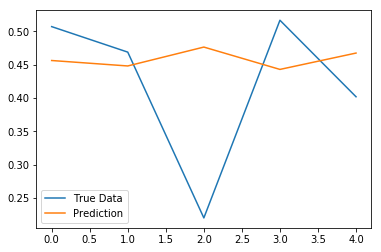

In [102]:


predicted = model.predict({'stock_input':train_X_stock, 
          'gap_input': train_X_gap, 
           'fai_input': train_X_fai})
print(len(predicted))
predicted1 = predicted[:1]
print(len(predicted1))

predicted1 = np.reshape(predicted1,(-1,1))

#predicted2 = np.reshape(predicted2,(-1,1))

print(predicted1)
result1 = predicted1[:5]
#result2 = predicted2[:5]
#result3 = predicted3[:5]
#print (result1, result2, result3)
#result = scaler.inverse_transform(result)
#result = np.reshape(result,(-1,1))

#result = result[:5]
#print (result, test_stock_y)
score = mean_squared_error(result1, test_stock_y)
    
print("MSE: %f" % score)
plot_results(result1, test_stock_y)
#plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['acc'], label='test')
#plt.legend()
#plt.show()
#predicted = np.reshape(predicted,(-1,1))
#concat_predicted = series_to_supervised(predicted,1,1)
#print(concat_predicted.head())



In [31]:
#predicted= (predicted[1:2])
#print (predicted)
#l = len(predicted)
#predicted = np.reshape(predicted,(-1,1))

#print(predicted.shape, test_stock_y.shape)
#print ( predicted[:5])
#print (concat_predicted[:5])
#result = concat_predicted[:5]
#result = predicted[:5]
#
#print (result)
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_fai = scaler.fit_transform(result)
#result = series_to_supervised(result, 5, 5)
#result = scaler.inverse_transform(result)
#result = np.reshape(result,(-1,1))
#result = result[:5]
#print (result, test_stock_y)
#score = mean_squared_error(result, test_stock_y)
    
#print("MSE: %f" % score)
#plot_results(result, test_stock_y)

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

KeyError: 'val_loss'